# Import necessary libraries

In [1]:
import numpy as np
import pandas as pd
import tweepy
import requests
import re 
import json
import matplotlib.pyplot as plt
import datetime
import os
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Data Gathering

#### Read Twitter archive as a Panda's Dataframe.

In [2]:
# Import twitter archive as a dataframe

archive= pd.read_csv('twitter-archive-enhanced.csv')

- Explore the dataframe

In [353]:
archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None


#### Download the Image Predictions file

In [3]:
# download image predictions programmatically

url= 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response= requests.get(url)

file_name= url.split('/')[-1]

In [4]:
with open (file_name, mode='wb') as file:
    file.write(response.content)

In [5]:
image_preds_df = pd.read_csv('image-predictions.tsv',sep='\t')

In [6]:
image_preds_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


#### Use Tweepy to create an API Object and use it to create Tweet_json.text and then create a Pandas DataFrame called API_df containing data about tweets in the tweet archive of the WeRateDogs account.

In [7]:

consumer_key = '*******************'
consumer_secret = '*******************'
access_token = '*******************'
access_secret = '*******************'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth)

In [8]:
exp_tweet= api.get_status(archive.tweet_id[1000], tweet_mode= 'extended')
content= exp_tweet._json
print(content)

{'created_at': 'Wed Jun 29 01:23:16 +0000 2016', 'id': 747963614829678593, 'id_str': '747963614829678593', 'full_text': 'PUPPER NOOOOO BEHIND YOUUU 10/10 pls keep this pupper in your thoughts https://t.co/ZPfeRtOX0Q', 'truncated': False, 'display_text_range': [0, 70], 'entities': {'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 747963600220917761, 'id_str': '747963600220917761', 'indices': [71, 94], 'media_url': 'http://pbs.twimg.com/media/CmFM7ngXEAEitfh.jpg', 'media_url_https': 'https://pbs.twimg.com/media/CmFM7ngXEAEitfh.jpg', 'url': 'https://t.co/ZPfeRtOX0Q', 'display_url': 'pic.twitter.com/ZPfeRtOX0Q', 'expanded_url': 'https://twitter.com/dog_rates/status/747963614829678593/photo/1', 'type': 'photo', 'sizes': {'thumb': {'w': 150, 'h': 150, 'resize': 'crop'}, 'medium': {'w': 937, 'h': 632, 'resize': 'fit'}, 'small': {'w': 680, 'h': 459, 'resize': 'fit'}, 'large': {'w': 937, 'h': 632, 'resize': 'fit'}}}]}, 'extended_entities': {'media': [{'id': 74796

In [9]:
content.keys()

dict_keys(['created_at', 'id', 'id_str', 'full_text', 'truncated', 'display_text_range', 'entities', 'extended_entities', 'source', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place', 'contributors', 'is_quote_status', 'retweet_count', 'favorite_count', 'favorited', 'retweeted', 'possibly_sensitive', 'possibly_sensitive_appealable', 'lang'])

In [87]:
content['retweet_count']

2062

In [88]:
content['favorite_count']

5597

In [89]:
content['id']

747963614829678593

In [10]:
errors = []
if not os.path.isfile('tweet_json.txt'):
    # create the file and write on it
    with open ('tweet_json.txt', 'w') as file:
        for tweet_id in archive['tweet_id']:
            try:
                status = api.get_status(tweet_id, wait_on_rate_limit=True,  wait_on_rate_limit_notify=True, tweet_mode = 'extended')
                json.dump(status._json, file)
                file.write('\n')
            except Exception as e:
                print("Error on tweet id {}".format(tweet_id) + ";" + str(e))
                errors.append(tweet_id)


In [11]:
# read tweet_json.text file line by line and import it to a pandas dataframe
df_lst=[]
with open ('tweet_json.txt', 'r') as file:
    for line in file:
        tweet= json.loads(line)
        tweet_id= tweet['id']
        retweet_count= tweet['retweet_count']
        favorite_count=  tweet['favorite_count']
        user_count= tweet['user']['followers_count']
        df_lst.append({ 'tweet_id': tweet_id,
                       'retweet_count': retweet_count,
                       'favorite_count': favorite_count,
                       'user_count': user_count    
        })
        
api_df= pd.DataFrame(df_lst)
api_df.head()

,favorite_count,retweet_count,tweet_id,user_count
0,35078,7377,892420643555336193,8962764
1,30367,5497,892177421306343426,8962764
2,22829,3633,891815181378084864,8962764
3,38352,7556,891689557279858688,8962764
4,36631,8141,891327558926688256,8962764


# Data Assessing
- archive
- image_preds_df
- api_df

## Archive

In [92]:
archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [93]:
archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [94]:
# check retweets
retweets= archive.retweeted_status_id.notnull()

In [95]:
#check replies
replies= archive.in_reply_to_status_id.notnull()

In [96]:
# check if any type of dog is duplicated
types= ['doggo','floofer','pupper', 'puppo']
indexes=[]

for type in types:
    lst_= archive[archive[type] != 'None'].index.tolist()
    for i in lst_:
        indexes.append(i)

indexes= pd.DataFrame(indexes)
indexes= indexes[indexes.duplicated()]

In [97]:
indexes

,0
98,200
134,460
141,531
144,565
145,575
156,705
157,733
164,778
169,822
174,889


In [98]:
archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [99]:
archive[archive['rating_denominator'] > 10].rating_denominator.value_counts()



50     3
11     3
20     2
80     2
90     1
120    1
150    1
16     1
15     1
110    1
170    1
40     1
70     1
130    1
Name: rating_denominator, dtype: int64

In [100]:
archive[archive['rating_numerator'] > 10].rating_numerator.value_counts()

12      558
11      464
13      351
14       54
15        2
75        2
420       2
165       1
44        1
666       1
204       1
182       1
17        1
20        1
24        1
26        1
27        1
45        1
144       1
50        1
60        1
960       1
80        1
84        1
88        1
99        1
121       1
143       1
1776      1
Name: rating_numerator, dtype: int64

In [101]:
archive.name.value_counts()

None          745
a              55
Charlie        12
Oliver         11
Cooper         11
Lucy           11
Penny          10
Tucker         10
Lola           10
Winston         9
Bo              9
Sadie           8
the             8
Bailey          7
Buddy           7
an              7
Toby            7
Daisy           7
Scout           6
Milo            6
Dave            6
Jack            6
Koda            6
Leo             6
Jax             6
Stanley         6
Bella           6
Rusty           6
Oscar           6
Chester         5
             ... 
Leonidas        1
Ester           1
Stuart          1
Burt            1
Blakely         1
Mingus          1
Oddie           1
Clifford        1
Monster         1
life            1
Jaspers         1
Crawford        1
Doobert         1
Craig           1
Zeek            1
Rodney          1
Jameson         1
Trevith         1
Norman          1
Chesterson      1
River           1
Glacier         1
Derby           1
Kobe            1
Zoe       

## Image predictions

In [102]:
image_preds_df.sample(7)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
374,672995267319328768,https://pbs.twimg.com/media/CVb1mRiWcAADBsE.jpg,1,French_bulldog,0.719559,True,boxer,0.166927,True,Boston_bull,0.101354,True
249,670679630144274432,https://pbs.twimg.com/media/CU67jGSUkAAk_1Y.jpg,1,Ibizan_hound,0.342734,True,Brittany_spaniel,0.229065,True,Chihuahua,0.104029,True
410,673887867907739649,https://pbs.twimg.com/media/CVoha_IU4AAZ7vi.jpg,2,Brabancon_griffon,0.216767,True,Chihuahua,0.190958,True,golden_retriever,0.163288,True
908,700505138482569216,https://pbs.twimg.com/media/Cbixs3vUUAAqHHN.jpg,1,bath_towel,0.449684,False,Norwegian_elkhound,0.160205,True,Great_Dane,0.048666,True
1061,715200624753819648,https://pbs.twimg.com/media/CeznK6IWEAEFUPq.jpg,1,Chihuahua,0.956787,True,beagle,0.008383,True,Labrador_retriever,0.008344,True
1767,826958653328592898,https://pbs.twimg.com/media/C3nygbBWQAAjwcW.jpg,1,golden_retriever,0.617389,True,Labrador_retriever,0.337053,True,tennis_ball,0.008554,False
1363,761334018830917632,https://pbs.twimg.com/media/CpDNQGkWEAENiYZ.jpg,1,Norwegian_elkhound,0.822936,True,malinois,0.086152,True,German_shepherd,0.063333,True


In [104]:
image_preds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [105]:
# check if all tweets contain images
len(archive) - len(image_preds_df)

281

In [106]:
image_preds_df.dtypes

tweet_id      int64
jpg_url      object
img_num       int64
p1           object
p1_conf     float64
p1_dog         bool
p2           object
p2_conf     float64
p2_dog         bool
p3           object
p3_conf     float64
p3_dog         bool
dtype: object

In [108]:
 image_preds_df.p1_dog.value_counts()

True     1532
False     543
Name: p1_dog, dtype: int64

In [109]:
 image_preds_df.p2_dog.value_counts()

True     1553
False     522
Name: p2_dog, dtype: int64

In [110]:
 image_preds_df.p2_dog.value_counts()

True     1553
False     522
Name: p2_dog, dtype: int64

In [111]:
image_preds_df.p1.value_counts().idxmax()

'golden_retriever'

In [112]:
image_preds_df.p2.value_counts().idxmax()

'Labrador_retriever'

In [113]:
image_preds_df.p3.value_counts().idxmax()

'Labrador_retriever'

## API DataFrame

In [114]:
api_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 4 columns):
favorite_count    2331 non-null int64
retweet_count     2331 non-null int64
tweet_id          2331 non-null int64
user_count        2331 non-null int64
dtypes: int64(4)
memory usage: 72.9 KB


In [115]:
api_df.describe()

,favorite_count,retweet_count,tweet_id,user_count
count,2331.000000,2331.000000,2.331000e+03,2.331000e+03
mean,7324.812527,2594.406263,7.419079e+17,8.962785e+06
std,11376.618314,4388.984145,6.823170e+16,5.154439e+01
min,0.000000,1.000000,6.660209e+17,8.962764e+06
25%,1270.000000,526.500000,6.782670e+17,8.962768e+06
50%,3180.000000,1210.000000,7.182469e+17,8.962779e+06
75%,8953.500000,3005.000000,7.986692e+17,8.962799e+06
max,150836.000000,74473.000000,8.924206e+17,8.963224e+06


In [116]:
api_df.duplicated().sum()

0

In [117]:
all_columns= pd.Series(list(archive) + list(image_preds_df) + list(api_df))
all_columns[all_columns.duplicated()]

17    tweet_id
31    tweet_id
dtype: object

In [118]:
print('Records in the archive df: {}'.format(archive.shape[0]))
print('Records in the image predictions df: {}'.format(image_preds_df.shape[0]))
print('Records in the API df: {}'.format(api_df.shape[0]))

Records in the archive df: 2356
Records in the image predictions df: 2075
Records in the API df: 2331


## Quality 

- Dataframe contains retweeted tweets in tweet archive.
- Change timestamp column's data type to datetime in tweet archive.
- Type of dog should be a column that includes whether the dog is a doggo, fluffer, pupper or puppo.
- 281 Tweets do not contain images of dogs.
- Non-matching record values for all the dataframes.
- Inaccurate dog names (such, a, an) in tweet archive.
- Rating denominators should be a fixed value of 10 but it's not.
- Rating numerators contain non-sensible numbers as well.



    
## Tidiness

- Retweet Timestamp column from archive df is not needed
- In the image predictions dataframe: there are 3 columns for each prediction,3 columns for each prediction's confidence and 3 columns for whether the image contains a dog or not.


# Cleaning

#### Define
 drop all not null values from retweets and replies.

#### Clean


In [12]:
archive_clean= archive.copy()

retweets= archive_clean.retweeted_status_id.notnull()
replies= archive_clean.in_reply_to_status_id.notnull()

archive_clean.drop(archive_clean[retweets].index, inplace= True)
archive_clean.drop(archive_clean[replies].index, inplace=True)

#### Test

In [13]:
archive_clean.shape[0]

2097

#### Define

- Drop Retweet timestamp column.
- change timestamp data type from string to datetime.


#### Clean

In [14]:
archive_clean.drop(['retweeted_status_timestamp'], axis=1, inplace=True)

In [15]:
archive_clean['timestamp']= pd.to_datetime(archive['timestamp'])

#### Test

In [16]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 16 columns):
tweet_id                    2097 non-null int64
in_reply_to_status_id       0 non-null float64
in_reply_to_user_id         0 non-null float64
timestamp                   2097 non-null datetime64[ns]
source                      2097 non-null object
text                        2097 non-null object
retweeted_status_id         0 non-null float64
retweeted_status_user_id    0 non-null float64
expanded_urls               2094 non-null object
rating_numerator            2097 non-null int64
rating_denominator          2097 non-null int64
name                        2097 non-null object
doggo                       2097 non-null object
floofer                     2097 non-null object
pupper                      2097 non-null object
puppo                       2097 non-null object
dtypes: datetime64[ns](1), float64(4), int64(3), object(8)
memory usage: 278.5+ KB


#### Define
Combine dog types into one column by adding their values as strings and adding them to a new column.

#### Code

In [17]:
archive_clean['doggo']= archive_clean['doggo'].replace('None','')
archive_clean['floofer']= archive_clean['floofer'].replace('None','')
archive_clean['pupper']= archive_clean['pupper'].replace('None','')
archive_clean['puppo']= archive_clean['puppo'].replace('None','')

In [18]:
archive_clean['dog_type'] = archive_clean['doggo'] + archive_clean['floofer'] + archive_clean['pupper'] + archive_clean['puppo']

In [19]:
archive_clean['dog_type']= archive_clean['dog_type'].replace('doggopupper','doggo-pupper')
archive_clean['dog_type']= archive_clean['dog_type'].replace('doggofloofer','doggo-floofer')
archive_clean['dog_type']= archive_clean['dog_type'].replace('doggopuppo','doggo-puppo')

#### Test

In [20]:
archive_clean.dog_type.value_counts()

                 1761
pupper            221
doggo              72
puppo              23
floofer             9
doggo-pupper        9
doggo-puppo         1
doggo-floofer       1
Name: dog_type, dtype: int64

In [21]:
archive_clean.floofer.value_counts()

           2087
floofer      10
Name: floofer, dtype: int64

#### Define
drop any reduntat columns: doggo, floofer, pupper, puppo,in_reply_to_status_id,in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id         

#### Code

In [22]:
archive_clean.drop(['doggo','floofer','pupper','puppo'], axis=1, inplace=True)

In [23]:
archive_clean.drop(['in_reply_to_status_id','in_reply_to_user_id','retweeted_status_id','retweeted_status_user_id'], axis=1, inplace=True)

#### Test

In [375]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 9 columns):
tweet_id              2097 non-null int64
timestamp             2097 non-null datetime64[ns]
source                2097 non-null object
text                  2097 non-null object
expanded_urls         2094 non-null object
rating_numerator      2097 non-null int64
rating_denominator    2097 non-null int64
name                  2097 non-null object
dog_type              2097 non-null object
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 163.8+ KB


#### Define

- compare archive with image prediction df through tweet id and remove all records that do not contain id. 


#### Code

In [24]:
# create a copy of image predictions df
image_preds_clean= image_preds_df.copy()

# Create a list of tweet ids that contain an image.
tweets_cont_imgs= list(image_preds_clean.tweet_id.unique())

In [25]:
# make sure all tweets exist in archive df

len(tweets_cont_imgs)== archive.tweet_id.isin(tweets_cont_imgs).sum()

True

In [26]:
# clean

archive_clean= archive_clean[archive_clean.tweet_id.isin(tweets_cont_imgs)]

#### Define
- remove all records in the image predictions df with tweet ids that are not in the archive df
- remove all records in api df with tweet ids not in the archive df

In [27]:
archive_clean.shape[0]

1971

#### Code

In [28]:
#create a list of tweet ids in archive df
arch_tweets= list(archive_clean.tweet_id.unique())

# drop all records that are not in the list

image_preds_clean= image_preds_clean[image_preds_clean.tweet_id.isin(arch_tweets)]

In [29]:
image_preds_clean.shape[0]== archive_clean.shape[0]

True

In [30]:
# create a copy of api df
api_df_clean= api_df.copy()

# drop all records with tweet ids not in the archive df
api_df_clean= api_df_clean[api_df_clean.tweet_id.isin(arch_tweets)]

#### Test

In [31]:
print('Records in the archive df: {}'.format(archive_clean.shape[0]))
print('Records in the image predictions df: {}'.format(image_preds_clean.shape[0]))
print('Records in the API df: {}'.format(api_df_clean.shape[0]))

Records in the archive df: 1971
Records in the image predictions df: 1971
Records in the API df: 1964


- we do not have retweet and favorite data  for 7 tweets.

#### Define 

for every wrong name, find dog names in the text column using regexand replacing the old names with the new ones.

#### Code

In [32]:
#non-sensible dog names contain 2 characters at most except for 'such'

archive_clean[archive_clean['name'].str.len() < 3].name.value_counts()


a     55
Bo     6
an     6
O      1
JD     1
Jo     1
my     1
Ed     1
Al     1
by     1
Mo     1
Name: name, dtype: int64

In [141]:
archive_clean[archive_clean['name'].str.len() < 3]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_type
56,881536004380872706,2017-07-02 15:32:16,"<a href=""http://twitter.com/download/iphone"" r...",Here is a pupper approaching maximum borkdrive...,https://twitter.com/dog_rates/status/881536004...,14,10,a,pupper
393,825876512159186944,2017-01-30 01:21:19,"<a href=""http://twitter.com/download/iphone"" r...",This is Mo. No one will push him around in the...,https://twitter.com/dog_rates/status/825876512...,11,10,Mo,
449,819004803107983360,2017-01-11 02:15:36,"<a href=""http://twitter.com/download/iphone"" r...",This is Bo. He was a very good First Doggo. 14...,https://twitter.com/dog_rates/status/819004803...,14,10,Bo,doggo
553,804026241225523202,2016-11-30 18:16:08,"<a href=""http://twitter.com/download/iphone"" r...",This is Bo. He's going to make me cry. 13/10 p...,https://twitter.com/dog_rates/status/804026241...,13,10,Bo,
649,792913359805018113,2016-10-31 02:17:31,"<a href=""http://twitter.com/download/iphone"" r...",Here is a perfect example of someone who has t...,https://twitter.com/dog_rates/status/792913359...,13,10,a,
679,789137962068021249,2016-10-20 16:15:26,"<a href=""http://twitter.com/download/iphone"" r...",This is Bo. He's a West Congolese Bugaboop Snu...,https://twitter.com/dog_rates/status/789137962...,12,10,Bo,
775,776201521193218049,2016-09-14 23:30:38,"<a href=""http://twitter.com/download/iphone"" r...",This is O'Malley. That is how he sleeps. Doesn...,https://twitter.com/dog_rates/status/776201521...,10,10,O,
801,772581559778025472,2016-09-04 23:46:12,"<a href=""http://twitter.com/download/iphone"" r...",Guys this is getting so out of hand. We only r...,https://twitter.com/dog_rates/status/772581559...,10,10,a,
820,770414278348247044,2016-08-30 00:14:12,"<a href=""http://twitter.com/download/iphone"" r...",Meet Al Cabone. He's a gangsta puppa. Rather h...,https://twitter.com/dog_rates/status/770414278...,11,10,Al,
852,765395769549590528,2016-08-16 03:52:26,"<a href=""http://twitter.com/download/iphone"" r...",This is my dog. Her name is Zoey. She knows I'...,https://twitter.com/dog_rates/status/765395769...,13,10,my,


In [142]:
archive_clean.dtypes

tweet_id                       int64
timestamp             datetime64[ns]
source                        object
text                          object
expanded_urls                 object
rating_numerator               int64
rating_denominator             int64
name                          object
dog_type                      object
dtype: object

In [33]:
# select 'a', 'an', 'o', 'my' and replace them with correct dog names
pattern = re.compile(r'(?:name(?:d)?)\s{1}(?:is\s)?([A-Za-z]+)')
for index, row in archive_clean.iterrows():
    try:
        if len(row['name'])<3 and row['name'][0].islower():
            
            c_name= re.findall(pattern, row['text'])[0]
            archive_clean.loc[index, 'name']= archive_clean.loc[index, 'name'].replace(row['name'], c_name)
    except IndexError:
        archive_clean.loc[index, 'name']= np.nan
        

In [36]:
archive_clean.dtypes

tweet_id                       int64
timestamp             datetime64[ns]
source                        object
text                          object
expanded_urls                 object
rating_numerator               int64
rating_denominator             int64
name                          object
dog_type                      object
dtype: object

In [44]:
# remove dog names like 'such'
for index, row in archive_clean.iterrows():
    if str(row['name']).islower():
        archive_clean.loc[index, 'name']= np.nan

In [323]:
archive_clean.dtypes

tweet_id                       int64
timestamp             datetime64[ns]
source                        object
text                          object
expanded_urls                 object
rating_numerator               int64
rating_denominator             int64
name                          object
dog_type                      object
dtype: object

#### Test

In [45]:
archive_clean.name.value_counts(dropna=False)

None         524
NaN           76
Charlie       11
Lucy          10
Cooper        10
Oliver        10
Penny          9
Tucker         9
Sadie          8
Winston        8
Daisy          7
Lola           7
Toby           7
Jax            6
Bo             6
Bella          6
Koda           6
Stanley        6
Dave           5
Leo            5
Louis          5
Oscar          5
Scout          5
Milo           5
Chester        5
Rusty          5
Buddy          5
Bailey         5
Chip           4
Derek          4
            ... 
Mark           1
Doobert        1
Bradley        1
Wishes         1
Danny          1
Carbon         1
Mona           1
Eriq           1
Dook           1
Mimosa         1
Timison        1
Oshie          1
Frönq          1
Marlee         1
Diogi          1
Mollie         1
Erik           1
Puff           1
Logan          1
Sparky         1
Hubertson      1
Terrance       1
Gòrdón         1
Sundance       1
Mary           1
Stubert        1
Finnegus       1
Link          

#### Define
Fix denominator ratings to all be 10, fix numerator ratings to all be sensible.

#### Code

In [46]:
pd.set_option('display.max_colwidth', -1) 

In [47]:
#visually check images of tweets that have a rating higher than 10

t_id= archive_clean[archive_clean['rating_denominator'] >10].loc[:, ['tweet_id','rating_denominator', 'rating_numerator','text']]

In [48]:

t_id


,tweet_id,rating_denominator,rating_numerator,text
433,820690176645140481,70,84,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd
902,758467244762497024,150,165,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE
1068,740373189193256964,11,9,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ"
1120,731156023742988288,170,204,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv
1165,722974582966214656,20,4,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a
1202,716439118184652801,50,50,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq
1228,713900603437621249,90,99,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1
1254,710658690886586372,80,80,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12
1274,709198395643068416,50,45,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK"
1351,704054845121142784,50,60,Here is a whole flock of puppers. 60/50 I'll take the lot https://t.co/9dpcw6MdWa


In [49]:
t_id2= t_id['tweet_id'].tolist()

In [50]:
imgs=[]
for tweet in t_id2:
    imgs.append(image_preds_clean[image_preds_clean['tweet_id'] == tweet].loc[:,[ 'jpg_url', 'tweet_id']])


In [51]:
imgs

[                                              jpg_url            tweet_id
 1728  https://pbs.twimg.com/media/C2OtWr0VQAEnS9r.jpg  820690176645140481,
                                                                                       jpg_url  \
 1338  https://pbs.twimg.com/ext_tw_video_thumb/758467147756691456/pu/img/YTNzjRFDSPNXukmM.jpg   
 
                 tweet_id  
 1338  758467244762497024  ,
                                               jpg_url            tweet_id
 1196  https://pbs.twimg.com/media/CkZVdJ6WYAAXZ5A.jpg  740373189193256964,
                                               jpg_url            tweet_id
 1148  https://pbs.twimg.com/media/CiWWhVNUYAAab_r.jpg  731156023742988288,
                                               jpg_url            tweet_id
 1105  https://pbs.twimg.com/media/CgiFjIpWgAA4wVp.jpg  722974582966214656,
                                               jpg_url            tweet_id
 1071  https://pbs.twimg.com/media/CfFNk7cWAAA-hND.jpg  7164391181

In [52]:
archive_clean['dog_count']= archive_clean['rating_denominator']/10

In [318]:
archive_clean.dog_count.value_counts()

1.0     1954
5.0     3   
1.1     2   
8.0     2   
0.2     1   
0.7     1   
12.0    1   
11.0    1   
4.0     1   
9.0     1   
2.0     1   
17.0    1   
15.0    1   
7.0     1   
Name: dog_count, dtype: int64

In [53]:
archive_clean[archive_clean['dog_count'] <1]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_type,dog_count
516,810984652412424192,2016-12-19 23:06:23,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,"https://www.gofundme.com/sams-smile,https://twitter.com/dog_rates/status/810984652412424192/photo/1",24,7,Sam,,0.7
2335,666287406224695296,2015-11-16 16:11:11,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv,https://twitter.com/dog_rates/status/666287406224695296/photo/1,1,2,NaN,,0.2


In [54]:
# change numerator ratings

archive_clean['rating_numerator'] = archive_clean['rating_numerator']/archive_clean['dog_count'] 


In [55]:
#change denominator ratings
archive_clean['rating_denominator'] = archive_clean['rating_denominator']/archive_clean['dog_count'] 

In [56]:
# indexes 1165, 1662, 1068, 516, 2335 are to be changed manually

archive_clean.loc[1165, 'rating_numerator']= 13
archive_clean.loc[1662, 'rating_numerator']= 10
archive_clean.loc[1068, 'rating_numerator']= 14
archive_clean.loc[516, 'rating_numerator']= np.nan
archive_clean.loc[2335, 'rating_numerator']= 9
archive_clean.loc[2335, 'rating_denominator']= 10

In [57]:
#visually check images of tweets that have a rating higher than 10

t_id_num= archive_clean[archive_clean['rating_numerator'] >15].loc[:, ['tweet_id','rating_denominator', 'rating_numerator','text']]

In [58]:
t_id_num

,tweet_id,rating_denominator,rating_numerator,text
695,786709082849828864,10.0,75.0,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS"
763,778027034220126208,10.0,27.0,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq
979,749981277374128128,10.0,1776.0,This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh
1712,680494726643068929,10.0,26.0,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD
2074,670842764863651840,10.0,420.0,After so many requests... here you go.\n\nGood dogg. 420/10 https://t.co/yfAAo1gdeY


In [59]:
# fix numerators with indexes 695, 763, 1712 manually

archive_clean.loc[695, 'rating_numerator']= 9.75
archive_clean.loc[763, 'rating_numerator']= 11.27
archive_clean.loc[1712, 'rating_numerator']= 11.26


In [60]:
archive_clean.drop('dog_count', axis=1, inplace=True)

#### Test

In [61]:
archive_clean.loc[t_id.index, :]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_type
433,820690176645140481,2017-01-15 17:52:40,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,"https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1",12.0,10.0,None,
902,758467244762497024,2016-07-28 01:00:57,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,https://twitter.com/dog_rates/status/758467244762497024/video/1,11.0,10.0,None,
1068,740373189193256964,2016-06-08 02:41:38,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ","https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1",14.0,10.0,None,
1120,731156023742988288,2016-05-13 16:15:54,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,https://twitter.com/dog_rates/status/731156023742988288/photo/1,12.0,10.0,NaN,
1165,722974582966214656,2016-04-21 02:25:47,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,https://twitter.com/dog_rates/status/722974582966214656/photo/1,13.0,10.0,None,
1202,716439118184652801,2016-04-03 01:36:11,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,https://twitter.com/dog_rates/status/716439118184652801/photo/1,10.0,10.0,Bluebert,
1228,713900603437621249,2016-03-27 01:29:02,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,https://twitter.com/dog_rates/status/713900603437621249/photo/1,11.0,10.0,None,
1254,710658690886586372,2016-03-18 02:46:49,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,https://twitter.com/dog_rates/status/710658690886586372/photo/1,10.0,10.0,None,
1274,709198395643068416,2016-03-14 02:04:08,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",https://twitter.com/dog_rates/status/709198395643068416/photo/1,9.0,10.0,None,
1351,704054845121142784,2016-02-28 21:25:30,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a whole flock of puppers. 60/50 I'll take the lot https://t.co/9dpcw6MdWa,https://twitter.com/dog_rates/status/704054845121142784/photo/1,12.0,10.0,NaN,


In [62]:
archive_clean.rating_denominator.value_counts()

10.0    1971
Name: rating_denominator, dtype: int64

In [63]:
archive_clean.rating_numerator.value_counts()

12.00      450
10.00      420
11.00      397
13.00      254
9.00       151
8.00       95 
7.00       51 
14.00      34 
5.00       33 
6.00       32 
3.00       19 
4.00       15 
2.00       9  
1.00       4  
9.75       1  
0.00       1  
1776.00    1  
11.26      1  
11.27      1  
420.00     1  
Name: rating_numerator, dtype: int64

In [64]:
archive_clean.dtypes

tweet_id              int64         
timestamp             datetime64[ns]
source                object        
text                  object        
expanded_urls         object        
rating_numerator      float64       
rating_denominator    float64       
name                  object        
dog_type              object        
dtype: object

#### Define

- Change column names so they make more sense.
- Use Panda's wide to long function to have 1 prediction column, 1 confidence column, 1 column predicting whether it's a dog or not, a new column for prediction level.


#### Code

In [65]:
image_preds_clean.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [66]:
#change column names to easy-to-understand names

cols= ['tweet_id', 'jpg_url', 'img_num', 'prediction_1', 'confidence_1', 'is_dog_1',
      'prediction_2', 'confidence_2', 'is_dog_2',
      'prediction_3', 'confidence_3', 'is_dog_3']
image_preds_clean.columns=cols


In [68]:
image_preds_clean.head()

,tweet_id,jpg_url,img_num,prediction_1,confidence_1,is_dog_1,prediction_2,confidence_2,is_dog_2,prediction_3,confidence_3,is_dog_3
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [72]:
image_preds_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id        1971 non-null int64
jpg_url         1971 non-null object
img_num         1971 non-null int64
prediction_1    1971 non-null object
confidence_1    1971 non-null float64
is_dog_1        1971 non-null bool
prediction_2    1971 non-null object
confidence_2    1971 non-null float64
is_dog_2        1971 non-null bool
prediction_3    1971 non-null object
confidence_3    1971 non-null float64
is_dog_3        1971 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 159.8+ KB


In [73]:
image_preds_clean = pd.wide_to_long(image_preds_clean, stubnames=['prediction', 'confidence', 'is_dog'], 
    i=['tweet_id', 'jpg_url', 'img_num'], j='prediction_level', sep="_").reset_index()

####  Test

In [74]:
image_preds_clean.head()

,tweet_id,jpg_url,img_num,prediction_level,prediction,confidence,is_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,1,Welsh_springer_spaniel,0.465074,True
1,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,2,collie,0.156665,True
2,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,3,Shetland_sheepdog,0.061428,True
3,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,1,redbone,0.506826,True
4,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,2,miniature_pinscher,0.074192,True


In [75]:
image_preds_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5913 entries, 0 to 5912
Data columns (total 7 columns):
tweet_id            5913 non-null int64
jpg_url             5913 non-null object
img_num             5913 non-null int64
prediction_level    5913 non-null int64
prediction          5913 non-null object
confidence          5913 non-null float64
is_dog              5913 non-null bool
dtypes: bool(1), float64(1), int64(3), object(2)
memory usage: 283.0+ KB


### Saving cleaned dataframes to csv

In [76]:
archive_clean.to_csv('archive_clean.csv', index=False)

In [77]:
image_preds_clean.to_csv('image_preds_clean', index=False)

In [78]:
api_df_clean.to_csv('api_clean', index=False)

# Analysis and Visualization

In [2]:
archive_clean= pd.read_csv('archive_clean.csv')
image_preds_clean=pd.read_csv('image_preds_clean')
api_df_clean=pd.read_csv('api_clean')

In [3]:
#archive_clean.rating_numerator.value_counts().sort_values(ascending=False)

archive_clean= pd.merge(archive_clean, api_df_clean, on= 'tweet_id')

In [4]:
archive_clean['timestamp']= pd.to_datetime(archive_clean['timestamp'])

In [5]:
archive_clean_2=archive_clean.copy()

In [6]:
# make timestamp the index column
archive_clean_2.index= archive_clean_2['timestamp']

In [7]:
archive_clean_2.drop('timestamp',axis=1, inplace=True)

In [8]:
archive_clean_2.sort_index(inplace=True)

In [9]:
#average retweet counts
data_to_plot = archive_clean_2.groupby([(archive_clean_2.index.year),(archive_clean_2.index.month)]).retweet_count.mean()

In [10]:
#average favorite counts
data_to_plot_favs= archive_clean_2.groupby([(archive_clean_2.index.year),(archive_clean_2.index.month)]).favorite_count.mean()

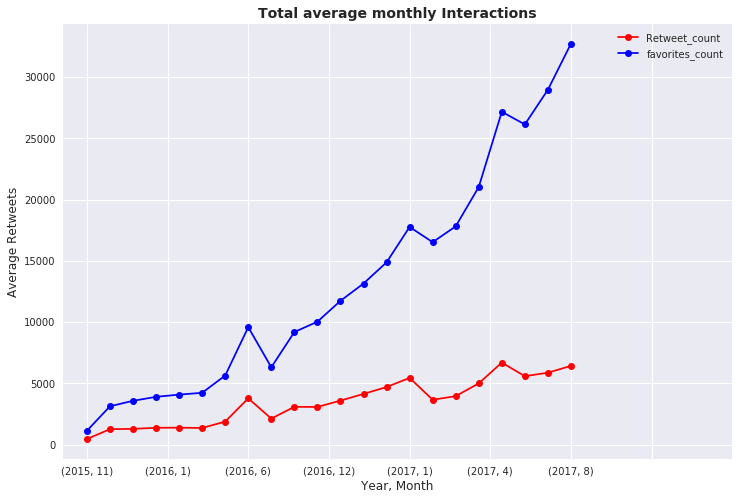

In [12]:
#plot
sns.set()

fig,axes=plt.subplots()

data_to_plot.plot(style='-ro', figsize=(12,8), label='Retweet_count')
data_to_plot_favs.plot(style='-ro',  color='b', label='favorites_count')

locs,labels=plt.xticks()
new_labels=[(2015,11),(2016,1),(2016,6),(2016,12),(2017,1),(2017,4),(2017,8)]
new_locs = np.arange(0,30,3.5)
plt.xticks(new_locs, new_labels)

plt.title('Total average monthly Interactions',fontweight='bold', fontsize=14)
plt.xlabel('Year, Month', fontsize=12)
plt.ylabel('Average Retweets', fontsize=12)

plt.legend()

### First Insight:
The Twitter account WeRateDogs gets more popular over the years. There is a linear increase in interaction level through favorites and retweets as shown by the figure above. There is a sudden spike in May, 2016 which could be a Tweet that went viral.

In [11]:
avg_rt_count= archive_clean_2.groupby('dog_type').retweet_count.mean()
avg_fav_count= archive_clean_2.groupby('dog_type').favorite_count.mean()

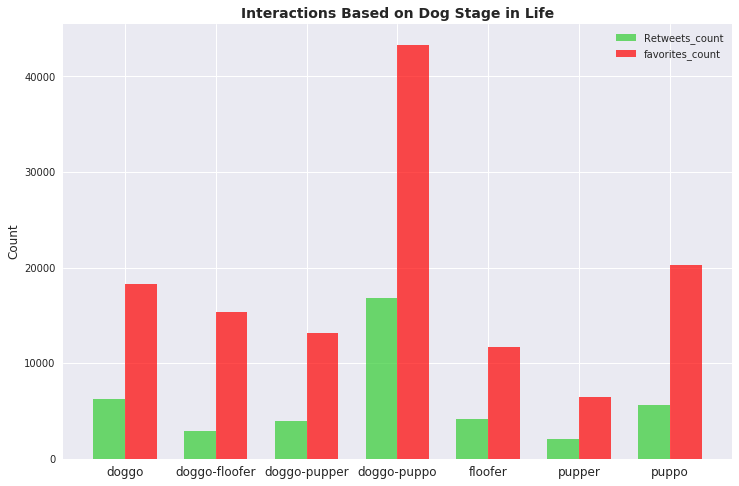

In [154]:
plt.figure(figsize=(12,8))
width = 0.35
ind = np.arange(len(avg_fav_count))
locations = ind + width / 2  # xtick locations
labels = avg_fav_count.index
plt.xticks(locations, labels, fontsize=12)

rt_bar = plt.bar(ind, avg_rt_count, width, color='limegreen', alpha=.7, label='Retweets_count')
fav_bar= plt.bar(ind + width, avg_fav_count, width, color='red', alpha=.7, label='favorites_count')


plt.title('Interactions Based on Dog Stage in Life',fontweight='bold', fontsize=14)
plt.ylabel('Count', fontsize=12)

plt.legend()


### Second Insight:
Interactions with Tweets through favoriting is always higher than the tweet being Retweeted. The stage of 'doggo-puppo' shows the highest favorites and retweets count, puppo is the second highest.

In [13]:
tst= pd.merge(archive_clean, image_preds_clean, on='tweet_id')

In [34]:
# ignoring false values 
tst.drop(tst[tst['is_dog']==False].index, inplace=True)

In [119]:
tst['prediction'].value_counts()

golden_retriever                  263
Labrador_retriever                263
Chihuahua                         178
Pembroke                          138
Cardigan                          112
Pomeranian                        102
toy_poodle                        101
pug                                92
chow                               91
French_bulldog                     89
cocker_spaniel                     87
Chesapeake_Bay_retriever           85
Eskimo_dog                         81
Siberian_husky                     72
beagle                             72
kuvasz                             70
malamute                           66
Staffordshire_bullterrier          64
Samoyed                            63
Pekinese                           62
kelpie                             59
miniature_pinscher                 55
American_Staffordshire_terrier     54
Great_Pyrenees                     52
miniature_poodle                   52
collie                             49
German_sheph

In [131]:
plt1= tst.groupby('prediction').favorite_count.sum().sort_values(ascending=False)[:20]


In [132]:
plt2= tst.groupby('prediction').rating_numerator.mean().sort_values(ascending=False)[:20]

Text(0,0.5,'Dog Species')

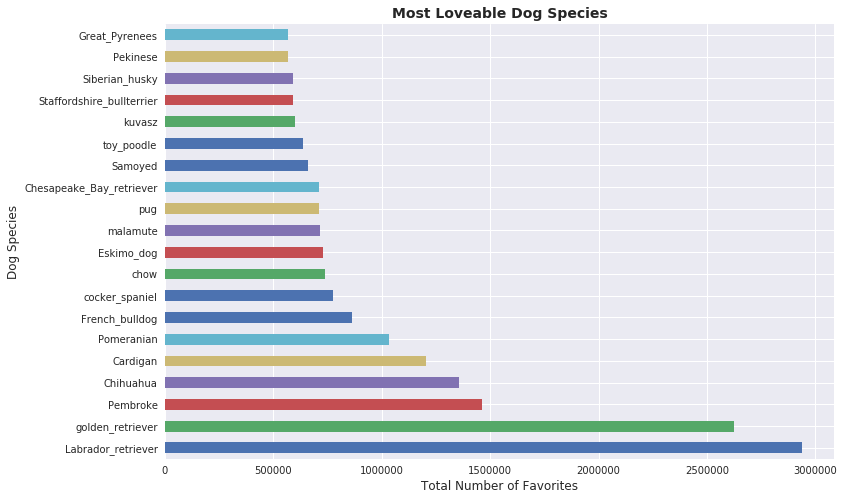

In [135]:
plt.figure(figsize=(12,8))
plt1.plot(kind='barh')
plt.title('Most Loveable Dog Species',fontweight='bold', fontsize=14)
plt.xlabel('Total Number of Favorites', fontsize=12)
plt.ylabel('Dog Species', fontsize=12)

### Third Insight:
Most Loveable dog species is Labrador Retriever as shown by the figure above. Next, comes the second Golden Retriever. The least popular dog species among followers of the WeRateDogs account is Great_Pyrenees.
    

Text(0,0.5,'Dog Species')

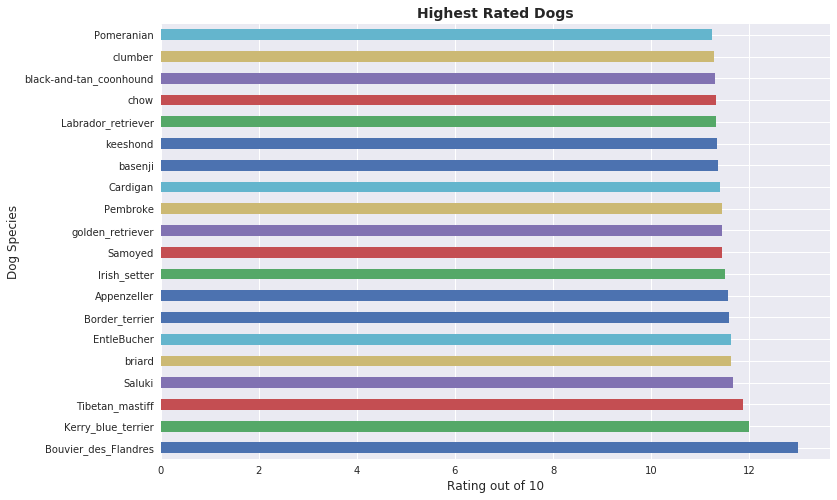

In [136]:
plt.figure(figsize=(12,8))
plt2.plot(kind='barh')
plt.title('Highest Rated Dogs',fontweight='bold', fontsize=14)
plt.xlabel('Rating out of 10', fontsize=12)
plt.ylabel('Dog Species', fontsize=12)

### Fourth Insight:
Golden Retrievers and Labrador Retrievers are also highly rated dogs but not the highest even though they gain they are the followers' favorite species. Bouvier Des Flandres dogs have the highest average rating. As we can see, not all highly rated dogs gain the level of interaction anticipated. The followers always have a mind of their own! 